# Model testing

Here I check how the neural cepstral coefficients network processes the incoming audio. Specifically, results are obtained on how the 'ch' consonant is processed.

List of consonants: ['b', 'd', 'g', 'p', 't', 'k', 'dx',
              'jh', 'ch', 's', 'sh', 'z', 'f', 'th',
              'v', 'dh', 'm', 'n', 'ng', 'l', 'r', 'w',
              'y', 'hh']

In [1]:
import phd
import nengo
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from phd.filters import melspace
from nengo.utils.stdlib import Timer
from nengo.utils.matplotlib import rasterplot
from matplotlib.ticker import ScalarFormatter
from IPython.display import Audio, display, SVG
from matplotlib.ticker import FormatStrFormatter

sns.set_style({"axes.spines.top": False})
sns.set_style({"axes.spines.right": False})
sns.set_context("paper",font_scale=1.7, rc={"lines.linewidth": 2})
sns.despine()

In [2]:
model = phd.sermo.AuditoryFeatures()
expt = phd.experimentsDef3.AuditoryFeaturesExperiment(model, phones=phd.timit.TIMIT.consonants)
expt.timit.filefilt.region = 8
expt.timit.filefilt.sent_type = 'I'
expt.seed = 20

audio_train_consonants = expt._get_audio(corpus="train")

In [3]:
from nengo.cache import NoDecoderCache

model = phd.sermo.AuditoryFeatures()
model.fs = 16000
model.audio = audio_train_consonants['ch'][0] # If you want to process any other consonant, replace 'ch'
net = model.build(nengo.Network(seed=0))

with net:
    ihc_p  = nengo.Probe(net.periphery.ihc, synapse=None) # Inner Hair Cell activity
    an_in_p = nengo.Probe(net.periphery.an.input, synapse=None) # auditory nerve
    an_p = nengo.Probe(net.periphery.an.add_neuron_output(), synapse=None) # spiking patterns
    an_out_p = nengo.Probe(net.periphery.an.output, synapse=None)
    cc_in_p = nengo.Probe(net.cepstra.input, synapse=None) #Cepstra input
    cc = nengo.Probe(net.cepstra.out_ea.input, synapse=None)# cepstra spiking patterns
    output = nengo.Probe(net.output, synapse=0.01)

_model = nengo.builder.Model(dt=0.001, decoder_cache=NoDecoderCache())    
sim = nengo.Simulator(net, model=_model)
sim.run(model.t_audio)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

# Inner hair cell activity

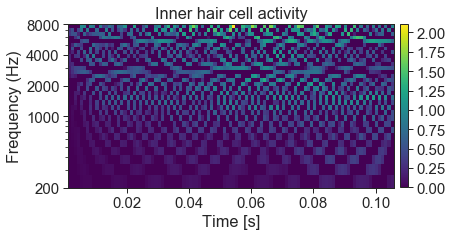

In [4]:
phd.plots.setup(figsize=(7, 3))
fig, ax = plt.subplots()
mesh = ax.pcolormesh(sim.trange(), model.freqs, sim.data[ihc_p].T,
                    linewidth=0, rasterized=True, cmap=plt.cm.viridis)
ax.set_yscale('log')
ax.set_yticks((200, 1000, 2000, 4000, 8000))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time [s]')
ax.set_ylim(model.freqs[0], model.freqs[-1])
ax.set_xlim(sim.trange()[0], sim.trange()[-1])
ax.set_title("Inner hair cell activity")
fig.colorbar(mesh, pad=0.015, use_gridspec=True, ax=ax)

# Auditory nerve input

In [7]:
phd.plots.setup(figsize=(7, 3))
fig, ax = plt.subplots()
mesh = ax.pcolormesh(sim.trange(), model.freqs, sim.data[an_in_p].T,
                    linewidth=0, rasterized=True, cmap=plt.cm.viridis)
ax.set_yscale('log')
ax.set_yticks((200, 1000, 2000, 4000, 8000))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time [s]')
ax.set_ylim(model.freqs[0], model.freqs[-1])
ax.set_xlim(sim.trange()[0], sim.trange()[-1])
ax.set_title("IHC-AN synaptic activity")
fig.colorbar(mesh, pad=0.015, use_gridspec=True, ax=ax)

# Spiking activity in the Auditory Nerve

In [8]:
import nengo
from nengo_extras.plot_spikes import (cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)
phd.plots.setup(figsize=(7, 3))
plot_spikes(*preprocess_spikes(sim.trange(),sim.data[an_p]))
plt.xlabel('Time [s]')
plt.ylabel('Neurons')
sns.despine()

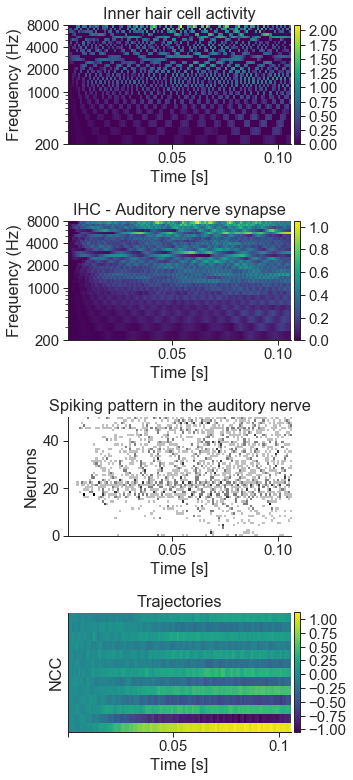

In [9]:
phd.plots.setup(figsize=(4, 13))

fig = plt.figure()
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax4 = fig.add_subplot(414)
plt.subplots_adjust(hspace = 0.65)
mesh = ax1.pcolormesh(sim.trange(), model.freqs, sim.data[ihc_p].T,
                     linewidth=0, rasterized=True, cmap=plt.cm.viridis)
ax1.set_yscale('log')
ax1.set_yticks((200, 1000, 2000, 4000, 8000))
ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time [s]')
ax1.set_ylim(model.freqs[0], model.freqs[-1])
ax1.set_xlim(sim.trange()[0], sim.trange()[-1])
ax1.set_title("Inner hair cell activity")
cbar_ax = fig.add_axes([0.91, 0.7524, 0.02, 0.1279]) # x,y, width, height

fig.colorbar(mesh, ticklocation='right', orientation='vertical', cax=cbar_ax)


mesh = ax2.pcolormesh(sim.trange(), model.freqs, sim.data[an_in_p].T,
                    linewidth=0, rasterized=True, cmap=plt.cm.viridis)
ax2.set_yscale('log')
ax2.set_yticks((200, 1000, 2000, 4000, 8000))
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.set_ylabel('Frequency (Hz)')
ax2.set_xlabel('Time [s]')
ax2.set_ylim(model.freqs[0], model.freqs[-1])
ax2.set_xlim(sim.trange()[0], sim.trange()[-1])
ax2.set_title("IHC - Auditory nerve synapse")
cbar_ax = fig.add_axes([0.91, 0.543, 0.02, 0.1279])

fig.colorbar(mesh, ticklocation='right', orientation='vertical', cax=cbar_ax)


plt.subplot(413)
ax3 = plt.gca()
plot_spikes(*preprocess_spikes(sim.trange(),sim.data[an_p]))
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Neurons')
ax3.set_title("Spiking pattern in the auditory nerve")
sns.despine()

mesh = ax4.pcolormesh(sim.data[output].T,linewidth=0, rasterized=True, cmap=plt.cm.viridis)
ax4.set_ylim(top=sim.data[output].shape[1])
ax4.set_xlim(right=sim.data[output].shape[0])
ax4.set_ylabel("NCC")
ax4.set_xlabel("Time [s]")
ax4.set_title("Trajectories")
#ax4.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
a = ax4.get_xticks(); a=a*0.001; a = np.round(a,3)
ax4.set_xticklabels(a)
ax4.get_yaxis().set_ticks([])
#let's hide the first value (0)
xticks = ax4.xaxis.get_major_ticks()
xticks[0].label1.set_visible(False)

cbar_ax = fig.add_axes([0.91, 0.125, 0.02, 0.1279])
fig.colorbar(mesh, ticklocation='right', orientation='vertical', cax=cbar_ax)
#ax4.set_xticks()

#fig.savefig('/Volumes/LeandroLV/TFM/Thesis/Figures/results/NCC-32filt-13cepstra-AAV2.svg', bbox_inches='tight', format='svg')